In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import os
import glob
import pandas as pd
import sys
import pyrkm
import torch

# Torch operations: set double type
torch.set_default_dtype(torch.float64)

# Select which gpu you want to use
gpu_id = 2
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    # otherwise multicore
    torch.set_num_threads(24)
print(device)

# Create directory where to store the model along training
try:
    os.makedirs('model_states')
except OSError:
    pass
# Create directory where to store the measures
try:
    os.makedirs('model_measures')
except OSError:
    pass

cpu


In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


# Load data
qmnist = unpickle("datasets/MNIST-120k")
data = qmnist['data']
train_data = np.reshape(data, newshape=(data.shape[0], 784)) / 255

# *Fix the seed
torch.manual_seed(42)

# Separate some data for testing
testing_data = train_data[:500, :]
testing_labels = qmnist['labels'][:500]
train_data = train_data[500:]
train_labels = qmnist['labels'][500:]

# train_data = torch.Tensor(train_data)
testing_data = torch.Tensor(testing_data)

# Use only 10000 data as Aurelien
train_data = torch.Tensor(train_data[:10000])
# and make them already binary
train_data = torch.where(train_data > 0.5, 1.0, 0.0).to(torch.float)
testing_data = torch.where(testing_data > 0.5, 1.0, 0.0).to(torch.float)

/tmp/ipykernel_26832/3489697653.py:10: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  train_data = np.reshape(data, newshape=(data.shape[0], 784)) / 255


/tmp/ipykernel_26832/3585741921.py:1: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  examples = pyrkm.make_grid(np.reshape(train_data[:64], newshape=(-1, 28, 28)))


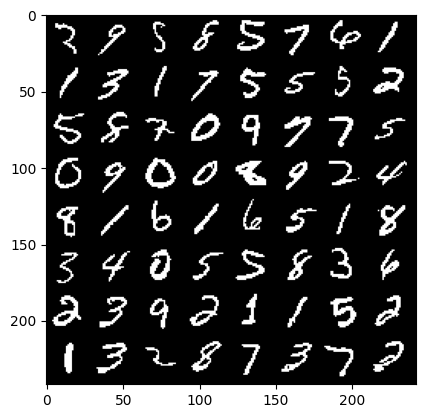

In [3]:
examples = pyrkm.make_grid(np.reshape(train_data[:64], newshape=(-1, 28, 28)))
plt.imshow(examples, cmap='gray')

## Training

In [4]:
# ***************************************
# Model parameters
max_epochs = 10000
batch_size = 64
lr = 0.001
optimizer = 'SGD'
energy_type = 'hopfield'
nhidden = 50
minWeight = -20
maxWeight = 20
# Set training hyperparameters
regul_to_use = 'l2'
l1factor = 1e-2
l2factor = 1e-2
k = 1
# train_algo='RDM'
train_algo = 'PCD'
centering = False
out_infix = 'test'
average_data = torch.Tensor(train_data).mean(0).to(torch.double)
model_beta = 1
mytype = torch.float32
train_data = train_data.to(mytype)
testing_data = testing_data.to(mytype)

In [5]:
# Define the model name
model_name = 'nh{}_{}{}_'.format(nhidden, energy_type, max_epochs)
if model_beta < 1000:
    model_name = '{}beta{}_'.format(model_name, model_beta)
else:
    model_name = '{}Deterministic_'.format(model_name)
if regul_to_use == 'l2':
    model_name = '{}l2{}_'.format(model_name, l2factor)
if regul_to_use == 'l1':
    model_name = '{}l1{}_'.format(model_name, l1factor)
model_name = '{}{}{}_{}_lr{}_bs{}_{}'.format(model_name, train_algo, k,
                                             optimizer, lr, batch_size,
                                             out_infix)
print('*** {} ***'.format(model_name), flush=True)

# Perepare the batchloader
train_loader = torch.utils.data.DataLoader(train_data.to(device),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

*** nh50_hopfield10000_beta1_l20.01_PCD1_SGD_lr0.001_bs64_test ***


In [6]:
# *****  Load the model and Train
# check if previous save point is available
is_loadable, model = pyrkm.load_model(model_name, delete_previous=False)
if not is_loadable:
    # *** Initialize
    model = pyrkm.RBM(model_name=model_name,
                      n_visible=784,
                      n_hidden=nhidden,
                      k=k,
                      lr=lr,
                      max_epochs=max_epochs,
                      energy_type=energy_type,
                      optimizer=optimizer,
                      batch_size=batch_size,
                      train_algo=train_algo,
                      centering=centering,
                      average_data=average_data,
                      model_beta=model_beta,
                      mytype=mytype)

    # *** Pretrain from T=1
    #pretrain_source = 'nh500_linear_circuit_4200000_RDM10_SGD_lr0.001_bs100__binary'
    #model.pretrain(pretrain_source)

# Perform the training
model.train(train_loader, testing_data.to(model.device), print_error=True)

** Model nh50_hopfield10000_beta1_l20.01_PCD1_SGD_lr0.001_bs64_test trained up to epoch 10000, so I load it
*** Training finished


## Load trained model

In [7]:
# model_name = '../../nh500_hopfield200000_beta0.1_RDM10_SGD_lr0.001_bs100__binary_pretrained'
# is_loadable, model = load_model(model_name, delete_previous=False)

## visualize trained model

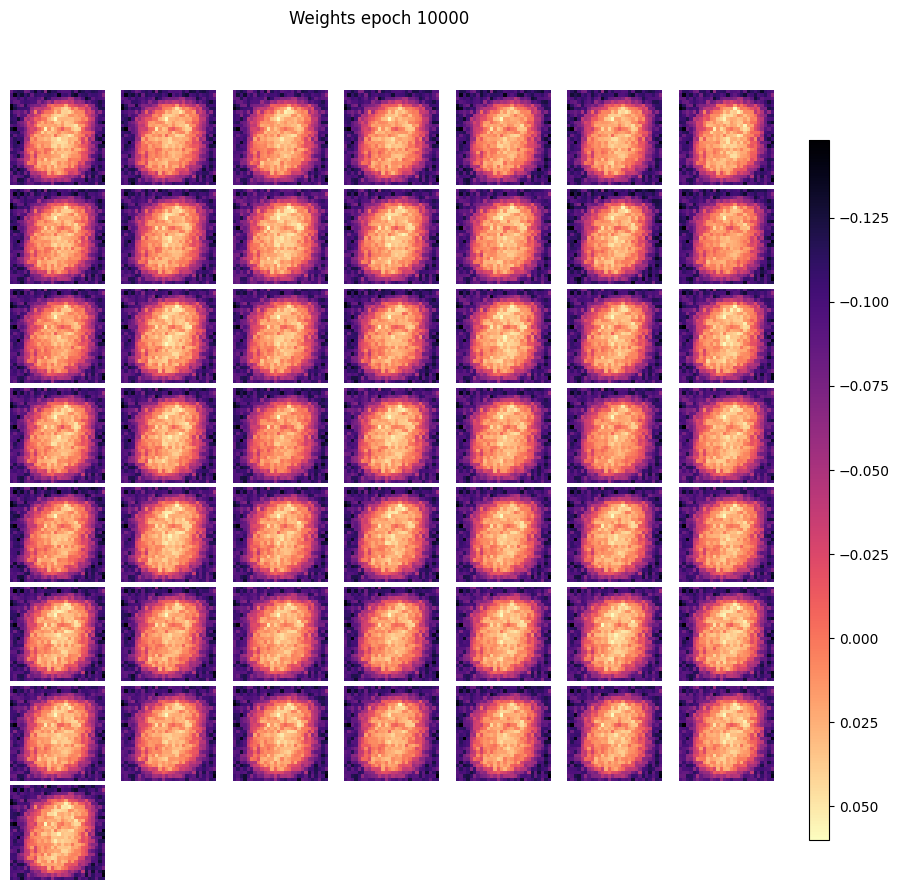

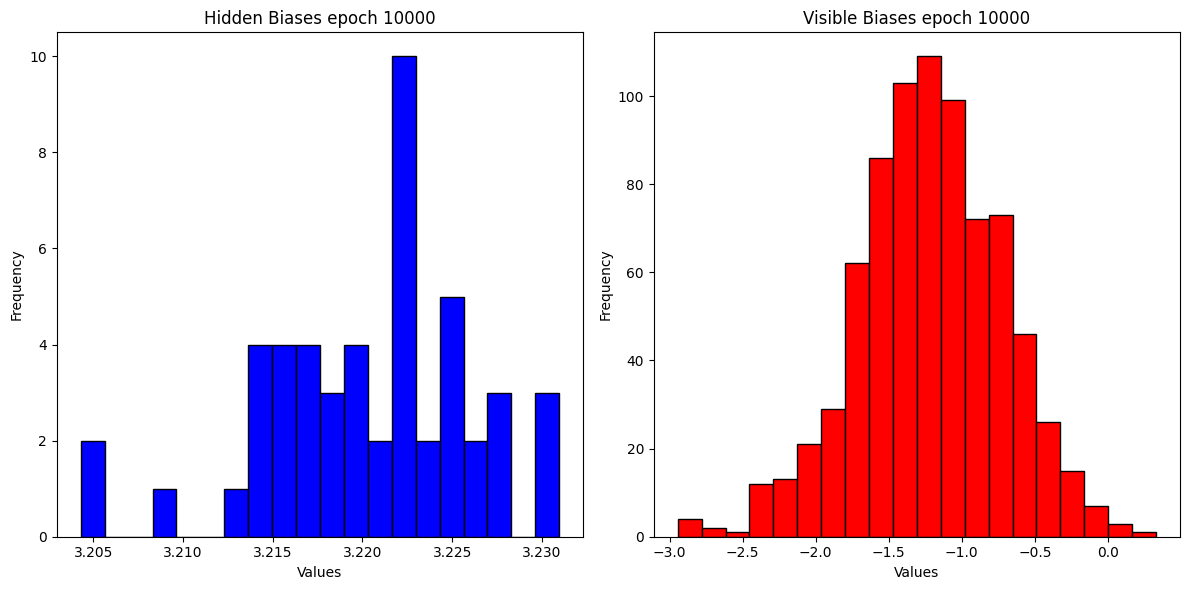

In [8]:
# visualize the weights using a grid. Each grid contains the weights for a single hidden unit
if hasattr(model, 'energy_type'):
    model.plot_weights(max_epochs)
    plt.show()
    model.plot_bias(max_epochs)
    plt.show()

/tmp/ipykernel_26832/2410776724.py:8: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  pyrkm.make_grid(np.reshape(v_reconstructed,


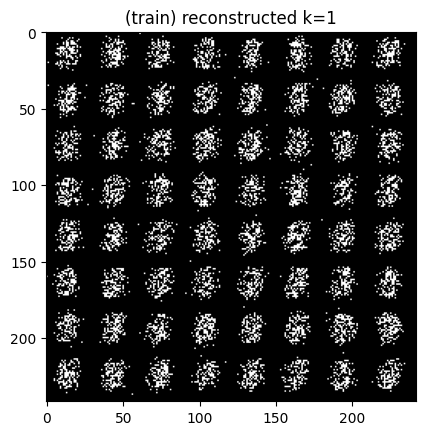

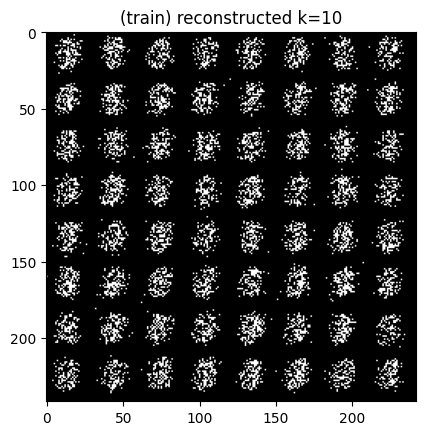

/tmp/ipykernel_26832/2410776724.py:13: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  pyrkm.make_grid(np.reshape(v_original, newshape=(-1, 28, 28))))


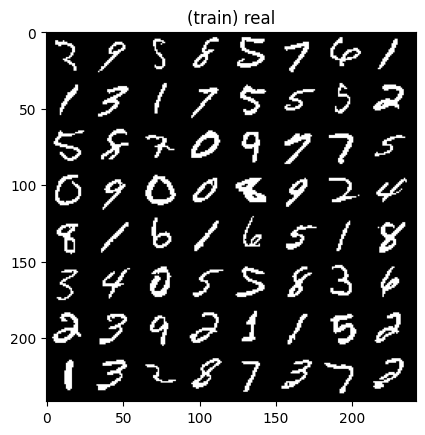

In [9]:
# Reconstruct some of the training data
testing_data = train_data[:64]
# reconstruct some images
for tg_multiple in [1, 10]:
    v_original, v_reconstructed = model.reconstruct(testing_data,
                                                    tg_multiple * k)
    pyrkm.show_and_save("(train) reconstructed k={}".format(tg_multiple * k),
                        pyrkm.make_grid(
                            np.reshape(v_reconstructed,
                                       newshape=(-1, 28, 28))),
                        save=False)
    plt.show()
pyrkm.show_and_save(
    "(train) real",
    pyrkm.make_grid(np.reshape(v_original, newshape=(-1, 28, 28))))
plt.show()

/tmp/ipykernel_26832/3801821320.py:5: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  pyrkm.make_grid(np.reshape(v_generated, newshape=(-1, 28, 28))))


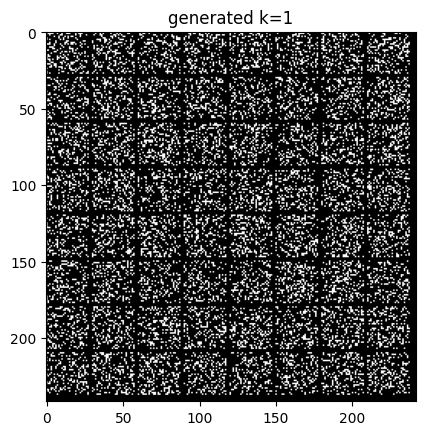

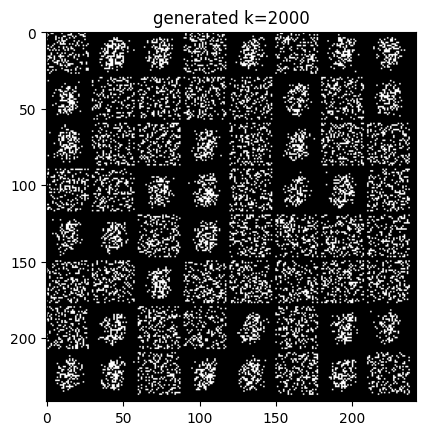

In [10]:
# generate some images
for tg_multiple in [1, 2000]:
    v_generated = model.generate(64, tg_multiple * k, from_visible=True)
    pyrkm.show_and_save(
        "generated k={}".format(tg_multiple * k),
        pyrkm.make_grid(np.reshape(v_generated, newshape=(-1, 28, 28))))
    plt.show()

Resuming training from epoch 25
Test Accuracy: 98.17%


/tmp/ipykernel_26832/2732381353.py:22: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  grid_image = pyrkm.make_grid(np.reshape(v_generated, newshape=(-1, 28, 28)))


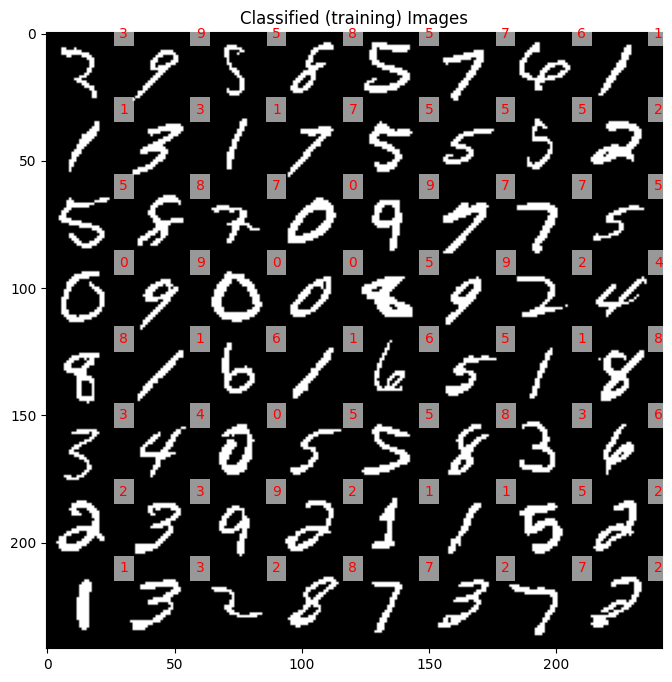

In [11]:
# Classify the generated images
test_set = (train_data, train_labels)
train_set = (train_data, train_labels)

# first train the classifier if not already done
classifier, accuracy = pyrkm.train_classifier(test_set,
                                              train_set,
                                              device,
                                              batch_size=64,
                                              num_epochs=25,
                                              learning_rate=0.01)

# take some random images from the testing data
v_generated = testing_data[:64]
v_generated_in = v_generated.to(device).reshape(-1, 1, 28, 28)

# Get predicted labels
predicted_labels = classifier(v_generated_in)
predicted_labels = torch.argmax(predicted_labels, dim=1).cpu().numpy()

# Display the images and predictions
grid_image = pyrkm.make_grid(np.reshape(v_generated, newshape=(-1, 28, 28)))
pyrkm.show_classification(file_name="Classified (training) Images",
                          img=grid_image,
                          cmap='gray',
                          labels=predicted_labels)

/tmp/ipykernel_26832/1272440281.py:25: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  grid_image = pyrkm.make_grid(np.reshape(selected_images, newshape=(-1, 28, 28)),


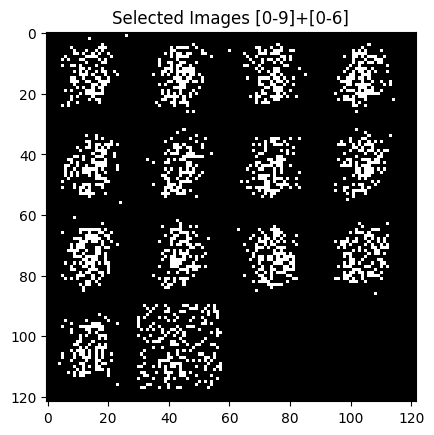

In [12]:
# Plot a selection of the generated images
desired_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5]
selected_images = []

# generate a batch of images
v_generated = model.generate(200, 10000, from_visible=True)
# predict the labels
v_generated_in = torch.Tensor(v_generated).to(device).reshape(
    -1, 1, 28, 28).to(torch.float32)
predicted_labels = classifier(v_generated_in)
predicted_labels = torch.argmax(predicted_labels, dim=1).cpu().numpy()

# In this test example, my model is bad
# so I pick digits from the training data

# select the images with the desired labels
for target in desired_labels:
    for i, label in enumerate(predicted_labels):
        if label == target:
            selected_images.append(v_generated[i])
            predicted_labels[i] = -1
            break

# plot the selected images
grid_image = pyrkm.make_grid(np.reshape(selected_images,
                                        newshape=(-1, 28, 28)),
                             nrow=4)
pyrkm.show_and_save("Selected Images [0-9]+[0-6]", grid_image, cmap='gray')

/tmp/ipykernel_26832/163089317.py:18: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  grid_image = pyrkm.make_grid(np.reshape(selected_images, newshape=(-1, 28, 28)),


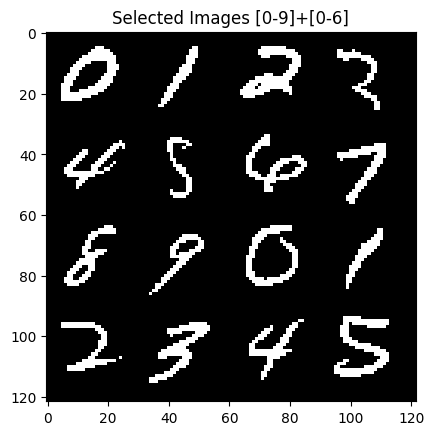

In [13]:
# If the model is bad, we can use the training data to make this panel and test the classifier
desired_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5]
selected_images = []

v_generated = testing_data[:200]
v_generated_in = torch.Tensor(v_generated).to(device).reshape(
    -1, 1, 28, 28).to(torch.float32)
predicted_labels = classifier(v_generated_in)
predicted_labels = torch.argmax(predicted_labels, dim=1).cpu().numpy()

for target in desired_labels:
    for i, label in enumerate(predicted_labels):
        if label == target:
            selected_images.append(v_generated[i])
            predicted_labels[i] = -1
            break

grid_image = pyrkm.make_grid(np.reshape(selected_images,
                                        newshape=(-1, 28, 28)),
                             nrow=4)
pyrkm.show_and_save("Selected Images [0-9]+[0-6]", grid_image, cmap='gray')

## Read power, energy, and time

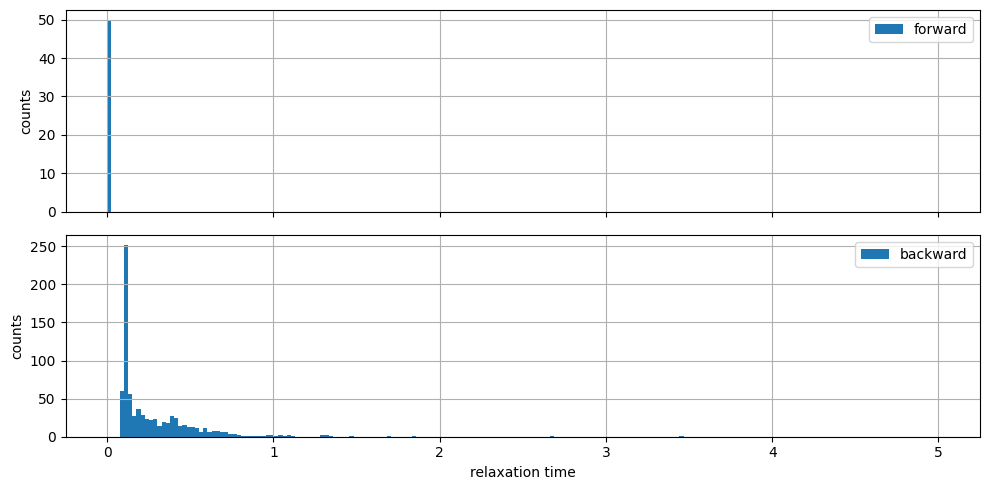

In [14]:
# plot the histogram of the relaxation times
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True, tight_layout=True)
# define the bins
bins = np.linspace(0, 5, 200)
axs[0].hist(model.relax_t_f.cpu().numpy(), bins=bins, label='forward')
axs[1].hist(model.relax_t_b.cpu().numpy(), bins=bins, label='backward')
axs[1].set_xlabel('relaxation time')
[ax.set_ylabel('counts') for ax in axs]
[ax.legend() for ax in axs]
# show grid
[ax.grid() for ax in axs]
plt.show()

In [15]:
filename_list = glob.glob('model_states/{}_t*.pkl'.format(model_name))
all_loadpoints = sorted(
    [int(x.split('_t')[-1].split('.pkl')[0]) for x in filename_list])

In [16]:
energy_array = []
power_forward_array = []
power_backward_array = []
time_forward_array = []
time_backward_array = []
av_time_forward_array = []
av_time_backward_array = []
rec_error_train_array = []
rec_error_test_array = []
entropy_array = []
fid_array = []
for t in all_loadpoints:
    with open('model_states/{}_t{}.pkl'.format(model_name, t), "rb") as file:
        model = pickle.load(file)
        # physical measures
        energy_array.append(model.energy.cpu().numpy())
        power_forward_array.append(model.power_f.cpu().numpy())
        power_backward_array.append(model.power_b.cpu().numpy())
        t_f = model.relax_t_f.cpu().numpy()
        t_b = model.relax_t_b.cpu().numpy()
        time_forward_array.append(t_f)
        time_backward_array.append(t_b)
        av_time_forward_array.append(t_f.mean())
        av_time_backward_array.append(t_b.mean())

        # error
        k = model.k
        # Compute reconstruction error (averaged over pixels and samples)
        v_model = model.forward(train_data.to(model.device), k)
        rec_error_train = ((v_model -
                            train_data.to(model.device))**2).mean(1).mean(0)
        # Now compute the reconstruction error for the test set only
        v_model = model.forward(testing_data.to(model.device), k)
        rec_error_test = ((v_model -
                           testing_data.to(model.device))**2).mean(1).mean(0)
        rec_error_train_array.append(rec_error_train.cpu().numpy())
        rec_error_test_array.append(rec_error_test.cpu().numpy())

        # Entropy
        v_generated = model.generate(testing_data.shape[0],
                                     k,
                                     from_visible=True)
        entropy_array.append(
            pyrkm.Compute_S(testing_data.to(model.device), v_generated))

        # FID
        fid = pyrkm.Compute_FID(testing_data.to(model.device), v_generated)
        fid_array.append(fid)

# transform to np array
energy_array = np.array(energy_array)
power_forward_array = np.array(power_forward_array)
power_backward_array = np.array(power_backward_array)
time_forward_array = np.array(time_forward_array)
time_backward_array = np.array(time_backward_array)
av_time_forward_array = np.array(av_time_forward_array)
av_time_backward_array = np.array(av_time_backward_array)
rec_error_train_array = np.array(rec_error_train_array)
rec_error_test_array = np.array(rec_error_test_array)
entropy_array = np.array(entropy_array)
fid_array = np.array(fid_array)

/home/simone/.virtualenvs/pyrkm/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/simone/.virtualenvs/pyrkm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


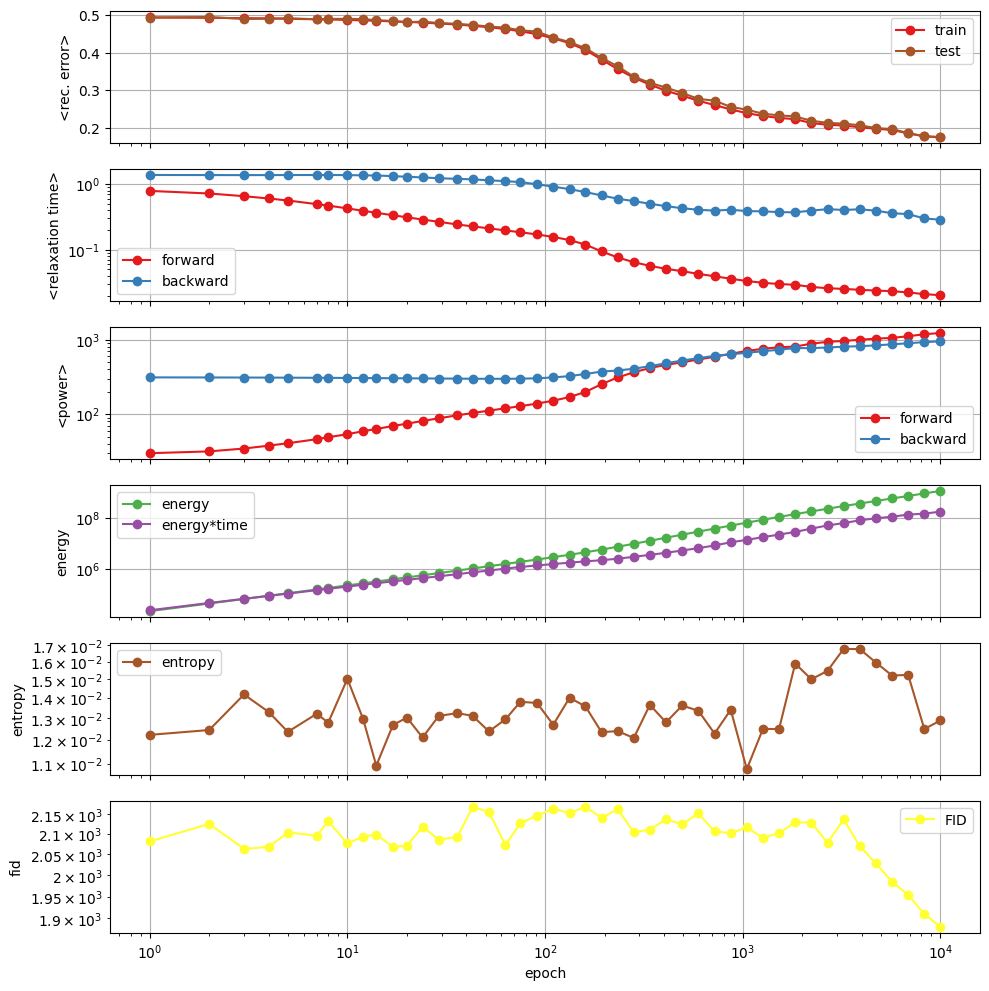

In [17]:
fig, axs = plt.subplots(6, 1, figsize=(10, 10), sharex=True, tight_layout=True)
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(7)]
axs[0].plot(all_loadpoints,
            rec_error_train_array,
            '-o',
            label='train',
            color=colors[0])
axs[0].plot(all_loadpoints,
            rec_error_test_array,
            '-o',
            label='test',
            color=colors[6])
axs[1].plot(all_loadpoints,
            av_time_forward_array,
            '-o',
            label='forward',
            color=colors[0])
axs[1].plot(all_loadpoints,
            av_time_backward_array,
            '-o',
            label='backward',
            color=colors[1])
axs[2].plot(all_loadpoints,
            power_forward_array,
            '-o',
            label='forward',
            color=colors[0])
axs[2].plot(all_loadpoints,
            power_backward_array,
            '-o',
            label='backward',
            color=colors[1])
axs[3].plot(all_loadpoints,
            energy_array,
            '-o',
            label='energy',
            color=colors[2])
axs[3].plot(all_loadpoints,
            energy_array * (av_time_backward_array + av_time_forward_array) /
            2,
            '-o',
            label='energy*time',
            color=colors[3])
axs[4].plot(all_loadpoints,
            entropy_array,
            '-o',
            label='entropy',
            color=colors[-1])
axs[5].plot(all_loadpoints, fid_array, '-o', label='FID', color=colors[-2])

axs[0].set_ylabel('<rec. error>')
axs[1].set_ylabel('<relaxation time>')
axs[2].set_ylabel('<power>')
axs[3].set_ylabel('energy')
axs[4].set_ylabel('entropy')
axs[5].set_ylabel('fid')

[ax.legend() for ax in axs]

axs[-1].set_xlabel('epoch')

# log scale
[ax.set_yscale('log') for ax in axs[1:]]
[ax.set_xscale('log') for ax in axs]
# grid
[ax.grid() for ax in axs]

plt.show()